# Electrochemical Impedance Spectroscopy (EIS) Analysis - Sandbox used to explore various fitting algorithms

## Functions of notebook

This notebook was built to:

*   Compile and retrieve relevant EIS spectra in the context of lithium-ion batteries across various SoCs and SoHs
-   Assess usage of impedance module to fit spectra
-   Assess other fitting algorithms, including ways to optimize circuit model initialization and other optimization algorithms

## Helper Functions

In [1]:
import pandas as pd
import os

In [8]:
proj_keyword_database = {'mendeley_data_1', 'sample_data'}

def process_and_export_raw_data(proj_keyword, export_dir_path):
    if proj_keyword == 'sample_data':
        input_raw_data = pd.read_csv(f'../data/raw/sample/exampleData.csv')
        export_data_agg = [input_raw_data]
    elif proj_keyword == 'mendeley_data_1':
        input_raw_data = pd.read_csv(f'../data/raw/mendeley/mend_1/Impedance_data.csv')
        # Remove headers
        input_raw_data = input_raw_data.iloc[1:]
        # Split the concatenated DataFrame into individual DataFrames
        num_cols = 3
        export_data_agg = [input_raw_data.iloc[:, i:i+num_cols] for i in range(1, len(input_raw_data.columns), num_cols)]
    if not os.path.exists(export_dir_path):
        os.makedirs(export_dir_path)
    for i, export_data in enumerate(export_data_agg):
        export_data.to_csv(f'{export_dir_path}/{proj_keyword}_{i+1}.csv', index=False)
    return

def fetch_processed_dir(proj_keyword, spectra_num):
    processed_dir_path = f'../data/processed'
    full_path = f'{processed_dir_path}/{proj_keyword}_{spectra_num}.csv'
    if not os.path.exists(full_path):
        process_and_export_raw_data(proj_keyword, processed_dir_path)
    return full_path

def fetch_eis_data(proj_keyword, spectra_num):
    if proj_keyword in proj_keyword_database:
        return preprocessing.readCSV(fetch_processed_dir(proj_keyword, spectra_num))
    else: 
        return None

## Assessing impedance module

In [23]:
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import matplotlib.pyplot as plt
from impedance.visualization import plot_nyquist

In [24]:
##############################################################
project_keyword = 'mendeley_data_1'
eis_spectra_num = 50

circuit = 'R0-p(R1,C1)-p(R2-Wo1,C2)'
initial_guess = [.01, .01, 100, .01, .05, 100, 1]
##############################################################

In [25]:
circuit = CustomCircuit(circuit, initial_guess=initial_guess)

# Load data from the example EIS data
frequencies, Z = fetch_eis_data(project_keyword, eis_spectra_num)
# keep only the impedance data in the first quandrant
frequencies, Z = preprocessing.ignoreBelowX(frequencies, Z)

circuit.fit(frequencies, Z)
Z_fit = circuit.predict(frequencies)

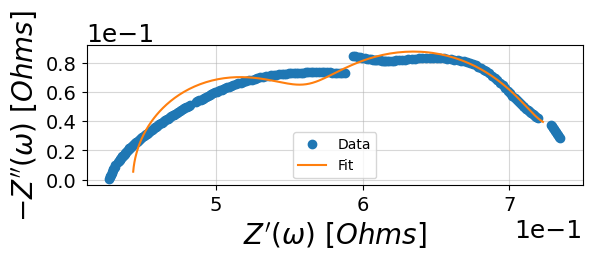

In [26]:
fig, ax = plt.subplots()
plot_nyquist(Z, fmt='o', scale=10, ax=ax)
plot_nyquist(Z_fit, fmt='-', scale=10, ax=ax)

plt.legend(['Data', 'Fit'])
plt.show()

## DRT

In [26]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import differential_evolution

# # Step 1: Load the data
# # Replace these arrays with your actual frequency and impedance data
# frequencies = frequencies
# impedance_real =  np.real(Z)
# impedance_imaginary = np.imag(Z)

# # Step 2: Convert impedance to magnitude and phase
# impedance_magnitude = np.sqrt(impedance_real**2 + impedance_imaginary**2)
# impedance_phase = np.arctan2(impedance_imaginary, impedance_real)

# # Step 3: Define the DE-DRT algorithm
# def drt_model(params, frequencies):
#     R_inf, C_inf, alpha, D, tau = params
#     impedance_model = R_inf + 1 / (1j * 2 * np.pi * frequencies * C_inf) ** alpha
#     for i in range(len(tau)):
#         impedance_model += D[i] * (1 / (1j * 2 * np.pi * frequencies * tau[i])) ** alpha
#     return impedance_model

# def objective_function(params, frequencies, impedance_magnitude, impedance_phase):
#     impedance_model = drt_model(params, frequencies)
#     error_magnitude = np.abs(impedance_model) - impedance_magnitude
#     error_phase = np.angle(impedance_model, deg=True) - impedance_phase
#     error = np.concatenate((error_magnitude, error_phase))
#     return np.sum(error**2)

# bounds = [
#     (0, 1e6),
#     (0, 1e-3),
#     (0, 1),
#     (1e-10, 1e-4),
#     (1e-6, 1e1)
# ]

# # Initial guess for parameters
# initial_guess = [1, 1, 0.5, 1, 10]

# # Run differential evolution optimization
# result = differential_evolution(objective_function, bounds, args=(frequencies, impedance_magnitude, impedance_phase), strategy='best1bin', popsize=15, maxiter=1000, tol=1e-6, mutation=(0.5, 1), recombination=0.7)

# # Extract optimized parameters
# R_inf_opt, C_inf_opt, alpha_opt, D_opt, tau_opt = result.x

# # Step 4: Plot the DRT spectrum
# plt.figure(figsize=(10, 5))
# plt.plot(frequencies, impedance_magnitude, 'bo-', label='Experimental Data')
# plt.plot(frequencies, np.abs(drt_model(result.x, frequencies)), 'r-', label='Fitted Model')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Impedance Magnitude (ohms)')
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.title('DRT Spectrum')
# plt.show()


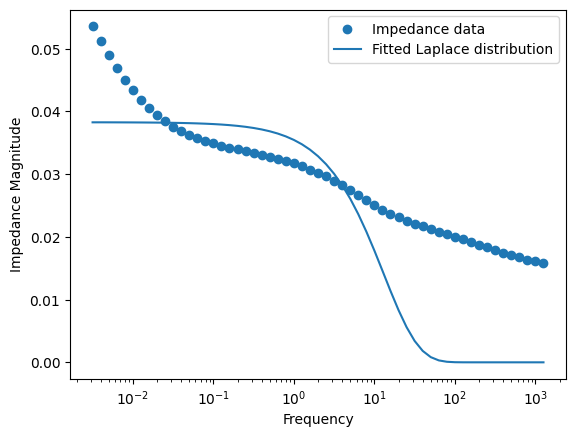

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Step 1: Load the data
# Replace these arrays with your actual frequency and impedance data
frequencies = frequencies
# impedance_real =  np.real(Z)
# impedance_imaginary = np.imag(Z)

# Define the Laplace distribution function
def laplace_dist(t, b, c):
    return (1/(2*b)) * np.exp(-np.abs(t-c)/b)

# Fit the Laplace distribution to the impedance data
popt, pcov = curve_fit(laplace_dist, frequencies, np.abs(Z), p0=[1, 1])

# Extract the parameters of the Laplace distribution
b, c = popt

# Plot the fitted distribution
plt.figure()
plt.scatter(frequencies, np.abs(Z), label='Impedance data')
plt.plot(frequencies, laplace_dist(frequencies, b, c), label='Fitted Laplace distribution')
plt.xscale('log')
plt.xlabel('Frequency')
plt.ylabel('Impedance Magnitude')
plt.legend()
plt.show()

# 